In [1]:
import matplotlib.pyplot as plt
#%matplotlib notebook
import numpy as np
from scipy.integrate import solve_ivp
import json

In [2]:
with open('paramsnew.json') as jsonFile:
    parameters = json.load(jsonFile)

run       = parameters["run"]
T         = parameters["T"]                # final time
n_steps   = parameters["n_steps"]          # number of time steps
K         = parameters["K"]                # elastic constant, sets diffusion lengthscale of S with Gamma0
Gammas    = parameters["Gammas"]           # rate of Q alignment with mol field H
Pi        = parameters["Pi"]               # strength of alignment
rho_in    = parameters["rho_in"]           # isotropic to nematic transition density, or "onset of order in the paper"
rhoseed   = parameters["rhoseed"]/rho_in   # seeding density, normalised by 100 mm^-2
rhoisoend = parameters["rhoisoend"]/rho_in # jamming density
rhonemend = parameters["rhonemend"]/rho_in # jamming density max for nematic substrate

mx        = parameters["mx"]
my        = parameters["my"]

times   = np.arange(0, T, T/n_steps)
Pij     = np.array([0, 0.5])
delta       = 0.01
rho_delt    = 0.5*rhoseed*np.log(delta/(1-delta))

savedir     = "ode/gammas_{:.2f}_rhoseed_{:.2f}_pi_{:.2f}_run_{}/".format(Gammas, rhoseed, Pi, run)

In [4]:
def ode(t, x, Gammas0, pi):
    S2      = 2*(x[0]**2 + x[1]**2)
    rhoend  = rhoisoend + (rhonemend - rhoisoend)*2*(S2)/(1+ S2)
    #rhoend  = rhoisoend + (rhonemend - rhoisoend)*np.tanh(S2)
    Gamma   = Gammas0*(np.tanh(rhoend-x[2]))
    y       = np.zeros_like(x)
    y[0:2]  = -Gamma*(1-x[2] + S2)*x[0:2] + Gamma*pi*Pij
    y[2]    = x[2] - (x[2]**2)/(rhoend)
    return y
def ode2(t, x, Gammas0, pi):
    S2      = 2*(x[:,:,:,0]**2 + x[:,:,:,1]**2)
    rhoend  = rhoisoend + (rhonemend - rhoisoend)*2*(S2)/(1+ S2)
    Gamma   = Gammas0[:,np.newaxis, np.newaxis]*(np.tanh(rhoend-x[:,:,:,2]))
    y       = np.zeros_like(x)
    y[:,:,:,0:2]  = -(Gamma*(1-x[:,:,:,2] + S2))[:,:,:,np.newaxis]*x[:,:,:,0:2] + (Gamma*pi[np.newaxis,np.newaxis, :]*Pij)[:,:,:,np.newaxis]
    y[:,:,:,2]    = x[:,:,:,2] - (x[:,:,:,2]**2)/(rhoend)
    return y

In [6]:
rhoseedvals = np.array([0.5, 1, 2, 2.5, 3, 3.5])/rho_in
gammasvals  = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.00, 1.05, 1.1])
pivals      = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1])
solutions   = np.zeros([len(gammasvals), len(rhoseedvals),len(pivals), 3, len(times)])

for g in np.arange(0, len(gammasvals)):
    for i in np.arange(0, len(rhoseedvals)):
        for p in np.arange(0, len(pivals)):
            solutions[g, i, p] += solve_ivp(ode, [0, T], np.array([0.01, 0.01, rhoseedvals[i]]), method='BDF', t_eval=times, args=(gammasvals[g], pivals[p])).y
print(np.shape(solutions))

#sols  = np.zeros([len(gammasvals), len(rhoseedvals),len(pivals), 3, len(times)])
#inits = np.array([0.01, 0.01, rhoseedvals[i]])
#sols += solve_ivp(ode2, [0, T], inits[np.newaxis, np.newaxis, np.newaxis, :], method='BDF', t_eval=times, args=(gammasvals, pivals)).y
#print(np.shape(sols))

rho = solutions[:,:,:, 2]
S2  = 2*np.sum(solutions[:,:,:,:2]**2, axis=3)
theta = np.arctan2(solutions[:,:,:, 1], solutions[:,:,:, 0])
theta = np.where(theta<1e-2, 0, theta)

(9, 6, 6, 3, 10000)


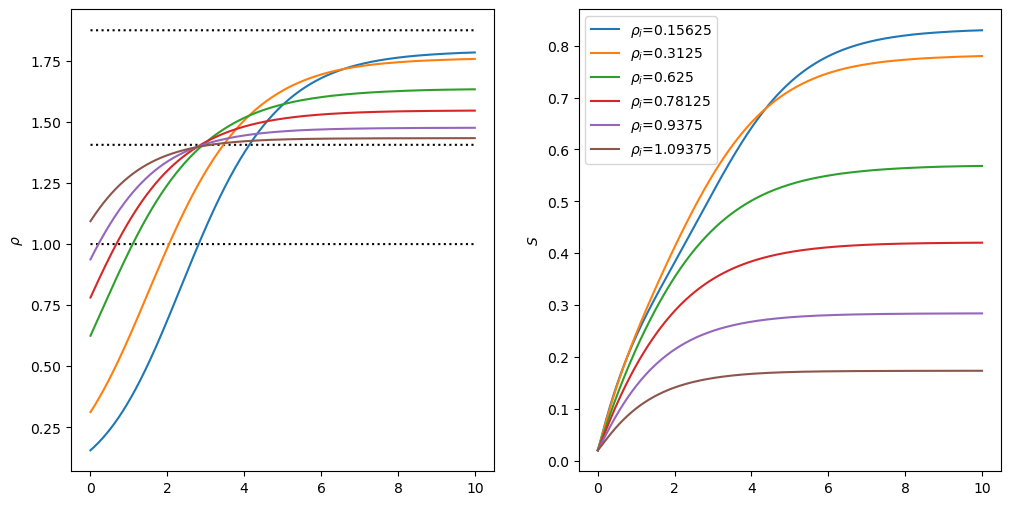

In [23]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
#plt.plot(times, rho, S2)
ax[0].plot(times, np.ones_like(times), linestyle='dotted', color='k')
ax[0].plot(times, np.ones_like(times)*rhonemend, linestyle='dotted', color='k')
ax[0].plot(times, np.ones_like(times)*rhoisoend, linestyle='dotted', color='k')
#plt.legend([r'$\rho$', r'$S^2$', r'rho_IN'], shadow=True)
for num in np.arange(0, np.int32(len(rhoseedvals))):
    ax[0].plot(times, rho[-1, num, 2])#, label=r'$\rho_i$={}'.format(rhoseedvals[num]))
    ax[1].plot(times, np.sqrt(S2[-1, num, 2]), label=r'$\rho_i$={}'.format(rhoseedvals[num]))
ax[1].set_ylabel(r'$S$')
ax[0].set_ylabel(r'$\rho$')
plt.legend()
plt.show()

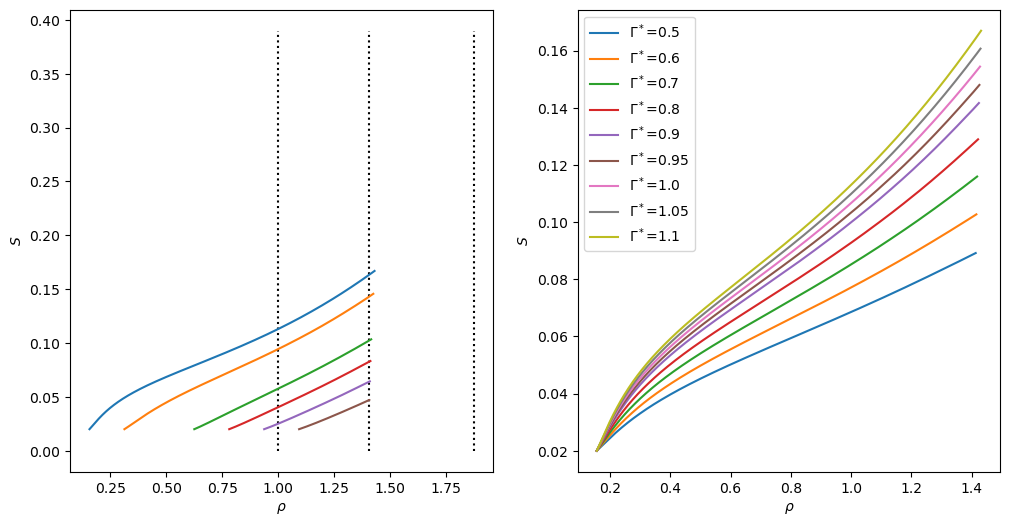

In [15]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
#plt.plot(times, rho, S2)
vert = np.arange(0, 40)
ax[0].plot(np.ones_like(vert), vert/100, linestyle='dotted', color='k')
ax[0].plot(np.ones_like(vert)*rhonemend, vert/100, linestyle='dotted', color='k')
ax[0].plot(np.ones_like(vert)*rhoisoend, vert/100, linestyle='dotted', color='k')
#plt.legend([r'$\rho$', r'$S^2$', r'rho_IN'], shadow=True)
for num in np.arange(0, np.int32(len(rhoseedvals))):
    ax[0].plot(rho[-1, num,0], np.sqrt(S2[-1, num,0]))#, label=r'$\rho_i$={}'.format(rhoseedvals[num]))
for g in np.arange(0, np.int32(len(gammasvals))):
    ax[1].plot(rho[g, 0, 0], np.sqrt(S2[g, 0, 0]), label=r'$\Gamma^*$={}'.format(gammasvals[g]))
ax[0].set_xlabel(r'$\rho$')
ax[1].set_xlabel(r'$\rho$')
ax[0].set_ylabel(r'$S$')
ax[1].set_ylabel(r'$S$')
plt.legend()
plt.show()

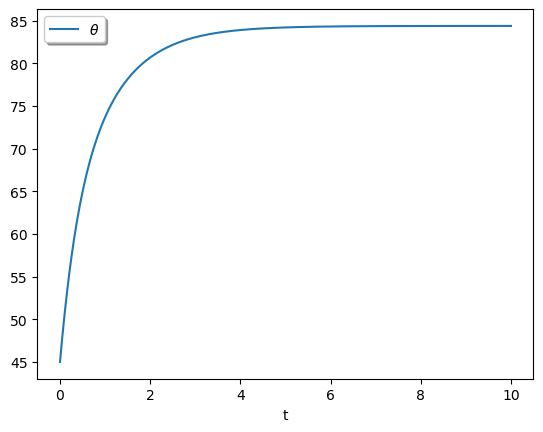

In [16]:
plt.plot(times, theta[0,0,0]*180/np.pi)
plt.xlabel('t')
plt.legend([r'$\theta$'], shadow=True)
plt.show()

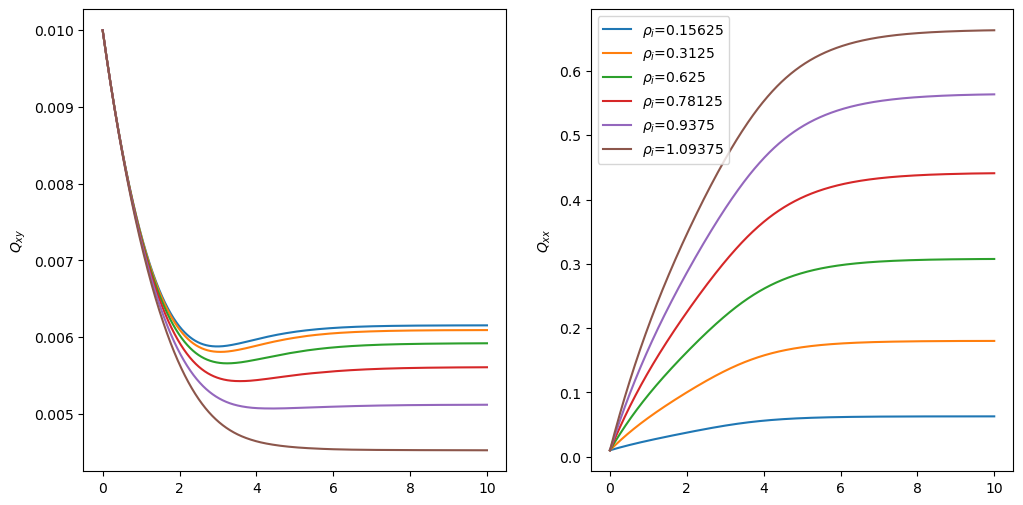

In [14]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
#plt.legend([r'$\rho$', r'$S^2$', r'rho_IN'], shadow=True)
for num in np.arange(0, np.int32(len(pivals))):
    ax[0].plot(times, solutions[0, 0, num, 0])#, label=r'$\rho_i$={}'.format(rhoseedvals[num]))
    ax[1].plot(times, solutions[0, 0, num, 1], label=r'$\rho_i$={}'.format(rhoseedvals[num]))
ax[1].set_ylabel(r'$Q_{xx}$')
ax[0].set_ylabel(r'$Q_{xy}$')
plt.legend()
plt.show()

-1.1487799625336474